In [1]:
import pandas as pd
import numpy as np
import logging
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from config import shuffled_csv, path_exps
from NN import NN_model, Sigmoid, MSE, L2_reg
from NN.utility import batch_train, batch_out, Model_Wrapper
from LBFGS import LBFGS
from testing import multi_run

data = pd.read_csv(shuffled_csv, index_col=0).to_numpy()
data = data[:100, :]
n_samples = data.shape[0]
X_data = data[:, :10]
Y_data = data[:, 10:]

Y_scaler = StandardScaler()
Y_scaled = Y_scaler.fit_transform(Y_data)

# np.random.seed(11)
model = NN_model([10, 20, 20, 2], Sigmoid, MSE)
model.init_weights()
reg_loss = L2_reg(1e-4)

# logging.basicConfig(level="INFO")
f = Model_Wrapper(model, X_data, Y_scaled, reg_loss)
x = model.Weights

Solver 		Mean runtime		variance runtime
ADAM		0.6692057132720948	0.0016816408723889253
LBFGS		0.6292788028717041	0.0035643988279980476


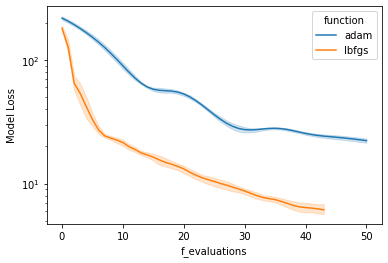

In [6]:
import seaborn as sns
from adam import adam_SGD

def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod() ** (1.0 / len(a))

def pair_vector(vector_list):
    maxlen = len(max(vector_list, key=len))
    for i in range(len(vector_list)):
        lastEl = len(vector_list[i]) - 1
        tmpArray = np.full((maxlen - lastEl - 1, 1), vector_list[i][lastEl])
        vector_list[i] = np.array(np.concatenate((vector_list[i], tmpArray), axis=None))
    return vector_list

runs = 5

adam_f_values = []
adam_runtimes = []
lbfgs_f_values = []
lbfgs_runtimes = []

for i in range(runs):
    solver = adam_SGD(max_feval = 50)
    model.init_weights()
    x = model.Weights
    status = solver.solve(f, x)
    f_values = solver.f_values
    adam_f_values.append(f_values)
    runtime = solver.runtime
    adam_runtimes.append(runtime)

for i in range(runs):
    solver = LBFGS(eps=1e-20,max_feval=50,M=500)
    model.init_weights()
    x = model.Weights
    status = solver.solve(f, x)
    f_values = solver.f_values
    lbfgs_f_values.append(f_values)
    runtime = solver.runtime
    lbfgs_runtimes.append(runtime)

print("Solver \t\tMean runtime\t\tvariance runtime")
print(f"ADAM\t\t{np.mean(adam_runtimes)}\t{np.var(adam_runtimes)}")
print(f"LBFGS\t\t{np.mean(lbfgs_runtimes)}\t{np.var(lbfgs_runtimes)}")

if lbfgs_f_values is not None and adam_f_values is not None: 
    run_1 = pair_vector(adam_f_values)
    run_2 = pair_vector(lbfgs_f_values)
    df_1 = pd.DataFrame(run_1).melt()
    df_1['function'] = ["adam"] * len(df_1.index)
    df_2 = pd.DataFrame(run_2).melt()
    df_2['function'] = ["lbfgs"] * len(df_2.index)
    result = pd.concat([df_1, df_2], axis=0)
    
    # Plot fevals
    fig = sns.lineplot(x="variable", y="value", hue="function", data=result, estimator=geo_mean)
    fig.set_yscale("log")
    fig.set(xlabel='f_evaluations', ylabel='Model Loss')